In [1]:
import numpy as np
import math
from numpy.linalg import multi_dot
import scipy.stats as st
import json

In [2]:
# # first, define our problem size
# n = 10
# alpha = np.random.random((n, 1))
# k = np.random.random((n, n))
# sigma = np.array([[k[i][i]] for i in range(n)])

# # TODO: figure out how to stitch together the r_opt values with the actual stock names
# stock_names = [f'stock_{i}' for i in range(n)]

# # TODO? figure out how to generate the confidence intervals of how much money you expect to make from this

# # TODO, pick one stock to be the baseline (stock_0). Figure out some way of comparing
# # stock_0's expected performance compared to our optimal solver

# # Katrina's draft:

# max_num_stocks = 5

# # DRAFT END

# # goal, generate some vector r such that:
# # sum(r) = 1.0
# # r represents our optimal investment portfolio

In [3]:

max_num_stocks = 10
investment_window_days = 30

In [4]:
# load the data
json_data = json.loads(open('tmp.txt', 'r').read())
covariance_matrix = np.array(json_data['covariance_matrix'])
mean_vector = np.array(json_data['mean_vector'])
ticker_to_index = json_data['ticker_to_index']

index_to_ticker = {v: k for k, v in ticker_to_index.items()}

In [5]:
# alpha is the mean
# sigma is the variance along the diagonal
# k is the covariance matrix

alpha = mean_vector * investment_window_days
sigma = np.diag(covariance_matrix) * investment_window_days
k = covariance_matrix * investment_window_days

In [6]:
# element-wise math

# square every term in alpha
alpha_element_squared = alpha * alpha
sigma_element_squared = sigma * sigma

# the 3.9 formula from
# https://maslov.bioengineering.illinois.edu/optimal_investment_ijtaf.pdf
alpha / (alpha_element_squared + sigma_element_squared)


array([  14.49112789,   13.69295559,   24.61918141,   27.35462832,
         40.90427614,   31.13378406,   24.98619915,   43.20063605,
         22.78937576,   24.98826185,   19.71653537,   27.55349365,
         19.81865137,   30.30104982,   83.08597394,  113.14666851,
         25.90161961,   20.66071411,   11.79245172,   27.44852928,
         23.30994908,   -9.77815444,    8.96037862,    9.64120035,
         17.24686082,   23.32287298,   23.25219262,    8.94895462,
         77.46125455,   22.85188616,   27.08910004,  -65.49804877,
         14.06293198,   40.41288353,   43.49021648,   13.41431561,
         36.46175276,   20.71714714,   21.89989118,   33.2854679 ,
         10.1032918 ,  -58.78693511,   21.62818224,   14.58788197,
         37.14509788,  -84.05603557,  -31.71444436,   19.89950717,
         21.9545842 ,   14.41556254,   33.36332825,   15.57214179,
         27.51378495,   20.97421771,   16.05396723,  120.75516333,
         25.06820295,   22.65247882,   57.17817663,   17.09863

In [7]:
# invert matrices
k_inv = np.linalg.inv(k)

# formula 3.10 from 
# https://maslov.bioengineering.illinois.edu/optimal_investment_ijtaf.pdf
r_opt = np.dot(k_inv, alpha)


In [8]:
# hints that I'm not sure how they all go together

# from formula 3.11
# you know that if \lambda >= \alpha_i, then we can ignore that term

# Maybe if you sort all fo the \alpha_i terms, you can see if a solution for lambda exists where all of the smaller
# values are ignored, and all of the larger values are effected by \lambda

# if you look at each term in the sum of 3.12, they are piecewise linear wrt. \lambda


In [9]:
# idea one to solve this: use line search
# main idea: function 3.12 is monotically decreasing
# so if we pick upper/lower bounds of lambda, we can just do a line search and call it a day
# monotonically decreasing means the derivative of the function wrt lambda is <= 0 across all values of lambda

# upper bound, we know that if lambda causes all of the terms to be zero, we went too far.
# i.e., alpha_i - upper_bound_lambda <= 0 \forall i
upper_bound_lambda = np.max(alpha)

# lower bound, we know that each term in the sum is >= 0 and <= the total sum term.
# so just find the lower bound of each term and take the maximum out of all of these terms
# for each term, lambda = alpha_i - alpha_i^2 - sigma_i^2
# I know this because I can do high-school algebra in my head... work it out on paper if you can't
lower_bound_lambda = np.min(alpha - (alpha_element_squared + sigma_element_squared))
# # # TODO, think about cases where there are zero values in r_opt
# # r_opt_top_stocks = r_opt[np.argsort(-r_opt)[:max_num_stocks]]
# # r_opt_top_stocks /= np.sum(r_opt_top_stocks)

# r_opt_top_stocks = [r_opt_with_names[best_stock_index][0] for best_stock_index in best_stock_indices]
# r_opt_top_stocks = np.array(r_opt_top_stocks_with_names) / np.sum(r_opt_top_stocks_with_names)
# r_opt_top_stocks

# r_opt_top_stocks_with_names = [r_opt_with_names[best_stock_index] for best_stock_index in best_stock_indices]
# r_opt_top_stocks_with_namespha - alpha_element_squared - sigma_element_squared)

print(lower_bound_lambda, upper_bound_lambda)

# now line search/binary search... first we need to evaluate the value of the 3.12 summation expression
def eval_expression(lambda_value):
    # subtract one so I can get something like \sum - 1 = 0 to solve.
    fractional_terms = (alpha - lambda_value) / (alpha_element_squared + sigma_element_squared)
    # heavyside function
    fractional_terms = np.maximum(fractional_terms, 0)
    return np.sum(fractional_terms) - 1

# sanity check, the correct value (0) is between the upper bound and lower bound
eval_expression(lower_bound_lambda), eval_expression(upper_bound_lambda)

# there's a tolerance term usually, more on that later
tolerance = 1e-9

# initialize our loop with our initial guess
lower_lambda = lower_bound_lambda
upper_lambda = upper_bound_lambda
middle_lambda = (lower_bound_lambda + upper_bound_lambda) / 2

iterations = 0
while np.abs(eval_expression(middle_lambda)) > tolerance:
    middle_value = eval_expression(middle_lambda)
    if middle_value > 0:
        lower_lambda = middle_lambda
    else:
        upper_lambda = middle_lambda
    middle_lambda = (lower_lambda + upper_lambda) / 2

    iterations += 1
    print(f'iteration: {iterations}, {middle_lambda}, {eval_expression(middle_lambda)}')


-0.043823124680115955 0.3313685267685651
iteration: 1, 0.23757061390639483, -0.75
iteration: 2, 0.1906716574753097, -0.08591682666142597
iteration: 3, 0.16722217925976712, 0.4208766378911639
iteration: 4, 0.1789469183675384, 0.16747990561486925
iteration: 5, 0.18480928792142404, 0.04078153947672192
iteration: 6, 0.18774047269836686, -0.02256764359235164
iteration: 7, 0.18627488030989545, 0.009106947942185029
iteration: 8, 0.18700767650413114, -0.006730347825082972
iteration: 9, 0.18664127840701328, 0.001188300058551306
iteration: 10, 0.1868244774555722, -0.0027710238832658884
iteration: 11, 0.18673287793129273, -0.0007913619123569582
iteration: 12, 0.186687078169153, 0.00019846907309717388
iteration: 13, 0.18670997805022288, -0.0002964464196302252
iteration: 14, 0.18669852810968796, -4.898867326674772e-05
iteration: 15, 0.1866928031394205, 7.47401999148245e-05
iteration: 16, 0.18669566562455422, 1.287576332398288e-05
iteration: 17, 0.1866970968671211, -1.8056454971659974e-05
iteration:

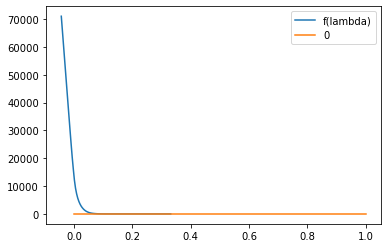

In [10]:
import matplotlib.pyplot as plt

x = np.linspace(lower_bound_lambda, upper_bound_lambda, 101)
plt.plot(x, [eval_expression(el) for el in x], label='f(lambda)')
plt.plot([0, 1], [0, 0], label='0')
plt.legend()

plt.show()


In [11]:
# get the optimal investment portfolio
r_opt = np.maximum(0, (alpha - middle_lambda) / (alpha_element_squared + sigma_element_squared))
r_opt = r_opt.flatten()

# r_opt_with_names = list(zip(r_opt, stock_names))
best_stock_indices = np.argsort(-r_opt)[:max_num_stocks]
best_stock_prices = r_opt[best_stock_indices]
best_stock_prices /= np.sum(best_stock_prices)

r_opt_top_stocks_with_names = []
for best_stock_price, best_stock_index in zip(best_stock_prices, best_stock_indices):
    r_opt_top_stocks_with_names.append([best_stock_price, index_to_ticker[best_stock_index]])
r_opt_top_stocks_with_names


[[0.6144043588723126, 'MRNA'],
 [0.3855956411276874, 'GE'],
 [0.0, 'A'],
 [0.0, 'NWSA'],
 [0.0, 'NWS'],
 [0.0, 'NWL'],
 [0.0, 'NVR'],
 [0.0, 'NVDA'],
 [0.0, 'NUE'],
 [0.0, 'NTRS']]

In [12]:
expected_val = np.dot(r_opt, alpha)


In [13]:
# brief lecture on probabilities (mean/variance)
# E[X]=mean(X), Var[X]=Variance(X)
# let a be a constant
# Var[X] = E[X^2] - E[X]^2
# aE[X] = E[aX]
# a^2Var[X] = Var[(aX)]
# Let v be some vector, K be the covariance matrix
# Var(Kv) = v^t K v

# we now have r_opt, find the mean and variance of investing in r_opt
# alpha, sigma

# Amber and Katrina's draft:

expected_val = np.dot(r_opt, alpha)

print("Mean/expected total return: ", expected_val)

# TODO: find the variance with weighted variables formula that includes r_opt values (Attempted/done 9/3/21)

# http://www.math.kent.edu/~reichel/courses/monte.carlo/alt4.7d.pdf

# (r_opt^T * covariance_matrix * r_opt)

# T is transpose. Matrix product operation (dot product)

# variance = sum((expected_return_array[i] - expected_val)**2 for i in range(len(expected_return_array) - 1)) / len(expected_return_array)

variance = multi_dot([r_opt.T, covariance_matrix, r_opt])

standard_dev = np.sqrt(variance)

print("Variance: ", variance)
print("Standard dev: ", standard_dev, "\n")

# Calculating confidence intervals:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html
for confidence_level in [0.99, 0.95, 0.85]:
    error = abs(st.norm.ppf((1-confidence_level)/2)) * standard_dev
    print(f"{confidence_level * 100}% confidence interval: {expected_val}", u"\u00B1", error)


Mean/expected total return:  0.2624050407537747
Variance:  0.0032800528711662254
Standard dev:  0.05727174583654863 

99.0% confidence interval: 0.2624050407537747 ± 0.14752224119118668
95.0% confidence interval: 0.2624050407537747 ± 0.1122505591713671
85.0% confidence interval: 0.2624050407537747 ± 0.08244448052730022


In [14]:
np.exp(0.11676983430967593)

1.1238607257395243

In [15]:
np.argsort(-alpha)[:max_num_stocks]

array([195, 313, 147, 314, 175, 249, 409, 192,  27, 247], dtype=int64)

In [16]:
[index_to_ticker[el] for el in np.argsort(-alpha)[:20]]

['GE',
 'MRNA',
 'DVN',
 'MRO',
 'FANG',
 'IVZ',
 'SIVB',
 'FTNT',
 'AMAT',
 'IT',
 'TPR',
 'PWR',
 'GNRC',
 'OXY',
 'ALB',
 'NUE',
 'ZBRA',
 'ENPH',
 'TECH',
 'DFS']

In [17]:
[alpha[el] for el in np.argsort(-alpha)[:20]]

[0.3313685267685651,
 0.2191240659353314,
 0.1400867242198729,
 0.11611008465720624,
 0.11352227701633087,
 0.11319832537608132,
 0.11309382608100262,
 0.111930390519782,
 0.10784290413149503,
 0.10777266991991276,
 0.1073836261129347,
 0.1053525050252863,
 0.10516875865731035,
 0.1043633779228129,
 0.10428536216028014,
 0.09943537220309658,
 0.09933313308572962,
 0.09863909547346643,
 0.09720499773050162,
 0.09716128182132173]

In [18]:
np.exp(0.010663833857211109) * 365

368.91312674213805

In [19]:
indices = np.array([ticker_to_index[ticker] for ticker in ['ETSY']])
np.array([[covariance_matrix[i, j] for i in indices] for j in indices])
r_opt[indices]
index_variance = np.array([[covariance_matrix[i, j] for i in indices] for j in indices])
index_mean = r_opt[indices]


In [20]:
variance = multi_dot([index_mean.T, index_variance, index_mean])
variance

0.0

In [21]:
np.sqrt(variance)

0.0

In [22]:
index_variance

array([[0.00151876]])

In [23]:
index_mean

array([0.])

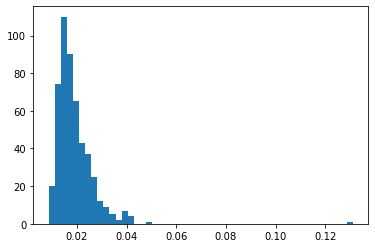

In [24]:
plt.hist(np.sqrt(np.diag(covariance_matrix)), bins=50)
plt.show()

In [25]:
np.sqrt(index_variance)

array([[0.03897125]])

### what do I want to do to clean up this code:
* combine everything into one notebook (should be a fairly easy script to run)
* put all of the important parameters that you might ever want to change (like investment length of time, or amount of time to look at historical data) at the top
* delete graphs that are unnecessary
* Write comments describing what the code does
* Small writeup on what we tried, why stuff worked/didn't work